### GPU kullanımı için gerekli izinlerin alınması

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


**Bulunduğumuz konumu çalışacağımız verilerin bulunduğu klasör ile değiştirme**

In [2]:
import os
os.chdir('/gdrive/My Drive/Covid-19-Xray-Norm/data')

###Gerekli Kütüphaneler ve Framework'ler

In [3]:
import os
import warnings
import pickle
import tensorflow
from tensorflow.keras import Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, confusion_matrix, recall_score, cohen_kappa_score, precision_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from itertools import cycle
from tensorflow.python.keras.engine.functional import Functional
from sklearn.utils import shuffle
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout, Activation
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.applications import ResNet50, InceptionResNetV2, DenseNet169, VGG19
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop, SGD, Nadam, Adadelta, Adagrad, Ftrl
from tensorflow.keras.losses import SparseCategoricalCrossentropy

### Verilerin Yüklenmesi

In [4]:
X_ = open('X.pickle', 'rb')
y_ = open('y.pickle', 'rb')

X = pickle.load(X_)
y = pickle.load(y_)
X_.close()
y_.close()

**Shuffle**

In [5]:
X, y = shuffle(X, y, random_state=0)
X = np.asarray(X)
y = np.asarray(y)

In [6]:
X.shape

(3886, 224, 224, 3)

In [7]:
X[96]

array([[[  1,   1,   1],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 17,  17,  17],
        [ 17,  17,  17],
        [ 17,  17,  17]],

       [[  1,   1,   1],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 18,  18,  18],
        [ 18,  18,  18],
        [ 18,  18,  18]],

       [[  1,   1,   1],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [ 20,  20,  20],
        [ 19,  19,  19],
        [ 19,  19,  19]],

       ...,

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [177, 177, 177],
        [177, 177, 177],
        [177, 177, 177]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [178, 178, 178],
        [178, 178, 178],
        [178, 178, 178]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [178, 178, 178],
        [178, 178, 178],
        [178, 178, 178]]

### Normalizasyon

In [8]:
X = (X/255.0).astype(np.float32)

In [9]:
X[96]

array([[[0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.06666667, 0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.07058824, 0.07058824, 0.07058824],
        [0.07058824, 0.07058824, 0.07058824],
        [0.07058824, 0.07058824, 0.07058824]],

       [[0.00392157, 0.00392157, 0.00392157],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.07843138, 0.07843138, 0.07843138],
        [0.07450981, 0.07450981, 0.07450981],
        [0.07450981, 0.07450981, 0.07450981]],

       ...,

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0

### Train-Test Bölünmesi

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.15, random_state=0)

**Bulunduğumuz konumu(data klasörü) sonuçları kaydedeceğimiz konum ile değiştirme**

In [11]:
os.chdir('/gdrive/My Drive/Covid-19-Xray-Norm/saved_models')

# **Denenecekler Kısmı**

In [12]:
epochs = 30           # Epoch sayısı
batch_size = 8     # Batch size        # 32, 16, 8
optimizer = Adam()    # Optimizer         # Adamax, RMSprop, SGD, Adagrad

### **Functions**

**Accuracy-Loss Plots**

In [13]:
def plot_acc_loss_eng(history):
  plt.style.use("seaborn-darkgrid")
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['acc']
  val_acc = history.history['val_acc']
  xc = range(epochs)

  plt.figure(1, figsize=(7,5))
  plt.plot(xc, train_loss)
  plt.plot(xc, val_loss)
  plt.xlabel('num of Epochs')
  plt.ylabel('loss')
  plt.title('train_loss vs val_loss')
  plt.grid(True)
  plt.legend(['train','val'])

  plt.figure(2, figsize=(7,5))
  plt.plot(xc, train_acc)
  plt.plot(xc, val_acc)
  plt.xlabel('num of Epochs')
  plt.ylabel('accuracy')
  plt.title('train_acc vs val_acc')
  plt.grid(True)
  plt.legend(['train','val'], loc = 4)
  plt.style.use("seaborn-darkgrid")

  plt.show()

In [14]:
def plot_acc_loss_tr(history):
  plt.style.use("seaborn-darkgrid")
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']
  train_acc = history.history['acc']
  val_acc = history.history['val_acc']
  xc = range(epochs)

  plt.figure(1, figsize=(7,5))
  plt.plot(xc, train_loss)
  plt.plot(xc, val_loss)
  plt.xlabel('Devir Sayısı')
  plt.ylabel('Kayıp')
  plt.title('Eğitim ve Test Hatası')
  plt.grid(True)
  plt.legend(['Eğitim','Doğrulama'])

  plt.figure(2, figsize=(7,5))
  plt.plot(xc, train_acc)
  plt.plot(xc, val_acc)
  plt.xlabel('Devir Sayısı')
  plt.ylabel('Başarım')
  plt.title('Eğitim ve Test Başarımı')
  plt.grid(True)
  plt.legend(['Eğitim', 'Doğrulama'], loc = 4)
  plt.style.use("seaborn-darkgrid")

  plt.show()

**Measurement Metrics**

In [15]:
def metric(X_test, y_test, model, model_name:str):
  warnings.filterwarnings("ignore")
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)

  print('\n\n{}  Model Accuracy Score:  {}'.format(model_name,  accuracy_score(y_test, y_pred)))
  print('\n\n{}  Model Balanced Accuracy Score: {} '.format(model_name, balanced_accuracy_score(y_test, y_pred)))
  print('\n\n{}  Model F1 Score: {} '.format(model_name, f1_score(y_test, y_pred, pos_label='positive', average='micro')))
  print('\n\n{}  Model Precision Score: {} '.format(model_name, precision_score(y_test, y_pred, pos_label='positive', average='micro')))
  print('\n\n{}  Model Cohen Kappa Score: {} '.format(model_name, cohen_kappa_score(y_test, y_pred)))
  print('\n\n{}  Model Recall Score: {} '.format(model_name, recall_score(y_test, y_pred, pos_label='positive', average='micro')))

**Confusion Matrix**

In [16]:
def cm_eng(X_test, y_test, model:Functional):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(cm, columns=["Covid", "Normal", "Viral Pneumonia"], index=["Covid", "Normal", "Viral Pneumonia"])
  plt.figure(figsize=(8, 6), dpi=100)
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');

In [17]:
def cm_tr(X_test, y_test, model:Functional):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  cm = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(cm, columns=["Covid", "Normal", "Viral Zatürre"], index=["Covid", "Normal", "Viral Zatürre"])
  plt.figure(figsize=(8, 6), dpi=100)
  sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');

**Roc Curve**

In [18]:
def plot_roc_curve_eng(X_test, y_test, model):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  plt.style.use("seaborn-darkgrid")
  target_test_roc = label_binarize(y_test, classes=[0, 1, 2])
  target_pred_roc = label_binarize(y_pred, classes=[0, 1, 2])
  n_classes = target_test_roc.shape[1]
  lw = 2

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


  plt.figure(dpi=100)
  colors = cycle(['purple', 'lime', 'blue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='ROC Curve of Class {0} (Area = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
  plt.xlim([-0.01, 1.0])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic to multi-class')
  plt.legend(loc="best")
  plt.show()

In [19]:
def plot_roc_curve_tr(X_test, y_test, model):
  y_pred = model.predict(X_test)
  y_pred = np.argmax(y_pred, axis=1)
  plt.style.use("seaborn-darkgrid")
  target_test_roc = label_binarize(y_test, classes=[0, 1, 2])
  target_pred_roc = label_binarize(y_pred, classes=[0, 1, 2])
  n_classes = target_test_roc.shape[1]
  lw = 2

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(target_test_roc[:,i], target_pred_roc[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])


  plt.figure(dpi=100)
  colors = cycle(['purple', 'lime', 'blue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
              label='{0} Sınıfının ROC Eğrisi (Bölge = {1:0.2f})'
              ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=lw, linestyle='--')
  plt.xlim([-0.01, 1.0])
  plt.ylim([-0.05, 1.05])
  plt.xlabel('Yanlış Pozitif Oranı')
  plt.ylabel('Doğru Pozitif Oranı')
  plt.title('Alıcı İşletim Karakteristiği')
  plt.legend(loc="best")
  plt.show()

## **ResNet50**

In [20]:
resnet50 = ResNet50(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
resnet50.trainable=False

94773248/94765736 [==============================] - 1s 0us/step


In [21]:
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = resnet50(inputs, training = True)

avg = GlobalAveragePooling2D()(x)

flat = Flatten()(avg)

batch = BatchNormalization()(flat)
drop = Dropout(0.25)(batch)
dense = Dense(512, activation='relu')(drop)
batch_2 = BatchNormalization()(dense)
drop_2 = Dropout(0.5)(batch_2)
outputs = tensorflow.keras.layers.Dense(3, activation=softmax)(drop_2)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics='acc')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 2048)              8192      
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               104908

#### **Train**

In [22]:
callback_list = [
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=5),
                 CSVLogger('resnet_50.csv', append=True, separator=';'),
                 ModelCheckpoint(filepath='resnet_50.h5', monitor='val_loss', mode='min',verbose=1, save_best_only=True)
]

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_split=.15,
                    batch_size=batch_size, 
                    callbacks=callback_list)

Epoch 1/30
351/351 [==============================] - 49s 40ms/step - loss: 0.7619 - acc: 0.7735 - val_loss: 0.5560 - val_acc: 0.8387

Epoch 00001: val_loss improved from inf to 0.55602, saving model to resnet_50.h5
Epoch 2/30
351/351 [==============================] - 13s 37ms/step - loss: 0.5111 - acc: 0.8285 - val_loss: 0.2253 - val_acc: 0.9153

Epoch 00002: val_loss improved from 0.55602 to 0.22526, saving model to resnet_50.h5
Epoch 3/30
351/351 [==============================] - 13s 37ms/step - loss: 0.4091 - acc: 0.8388 - val_loss: 0.2242 - val_acc: 0.9173

Epoch 00003: val_loss improved from 0.22526 to 0.22417, saving model to resnet_50.h5
Epoch 4/30
351/351 [==============================] - 13s 38ms/step - loss: 0.3696 - acc: 0.8625 - val_loss: 0.2164 - val_acc: 0.9214

Epoch 00004: val_loss improved from 0.22417 to 0.21644, saving model to resnet_50.h5
Epoch 5/30
351/351 [==============================] - 13s 38ms/step - loss: 0.3603 - acc: 0.8673 - val_loss: 0.1865 - val_ac

#### **Plot Acc - Loss**

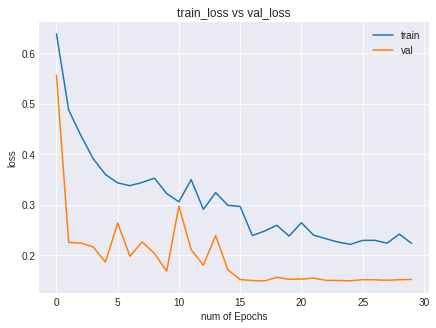

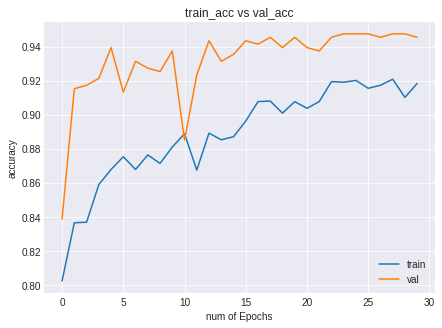

In [23]:
plot_acc_loss_eng(history)

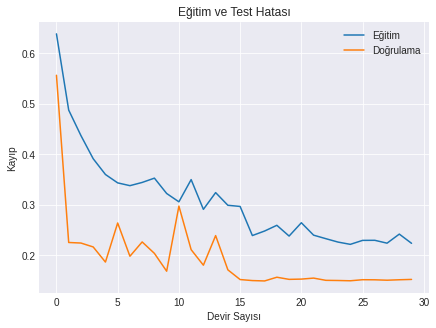

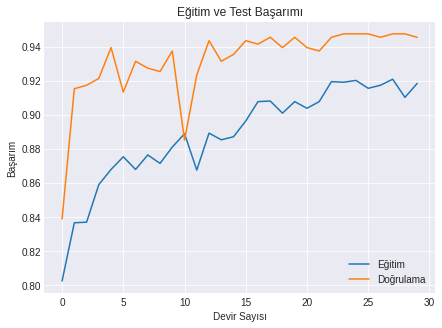

In [24]:
plot_acc_loss_tr(history)

#### **Metrics Results**

In [25]:
metric(X_test, y_test, model, model_name='ResNet50')



ResNet50  Model Accuracy Score:  0.9485420240137221


ResNet50  Model Balanced Accuracy Score: 0.9487695849746037 


ResNet50  Model F1 Score: 0.9485420240137221 


ResNet50  Model Precision Score: 0.9485420240137221 


ResNet50  Model Cohen Kappa Score: 0.9227251640267744 


ResNet50  Model Recall Score: 0.9485420240137221 


In [26]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 3s 96ms/step - loss: 0.1307 - acc: 0.9485


[0.13065245747566223, 0.9485419988632202]

#### **Confusion Matrix**

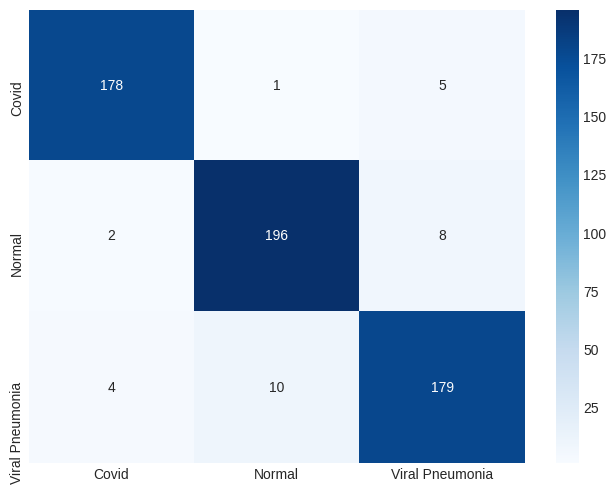

In [27]:
cm_eng(X_test, y_test, model)

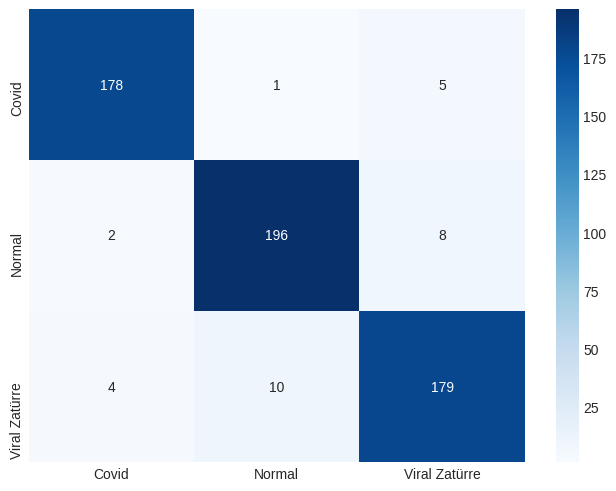

In [28]:
cm_tr(X_test, y_test, model)

#### **Roc Curve**

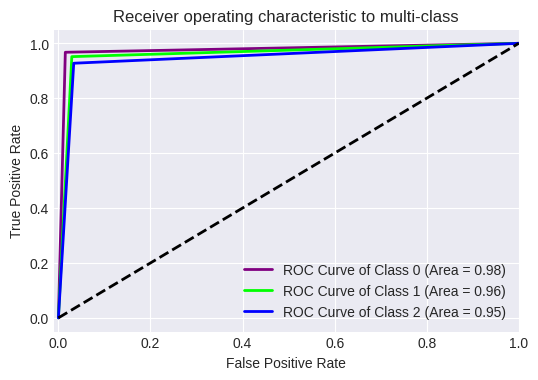

In [29]:
plot_roc_curve_eng(X_test, y_test, model)

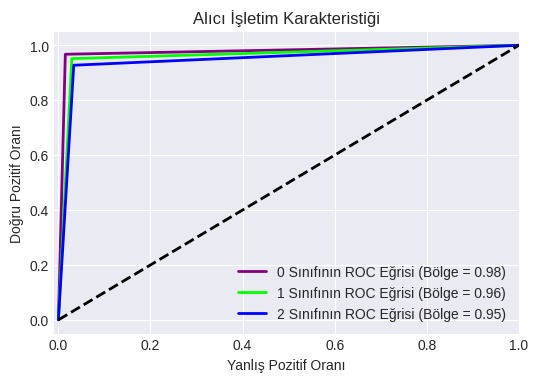

In [30]:
plot_roc_curve_tr(X_test, y_test, model)

## **InceptionResNetV2**

In [31]:
inceptionResnetv2 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
inceptionResnetv2.trainable=False

219062272/219055592 [==============================] - 1s 0us/step


In [32]:
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = inceptionResnetv2(inputs, training = True)

avg = GlobalAveragePooling2D()(x)

flat = Flatten()(avg)

batch = BatchNormalization()(flat)
drop = Dropout(0.25)(batch)
dense = Dense(512, activation='relu')(drop)
batch_2 = BatchNormalization()(dense)
drop_2 = Dropout(0.5)(batch_2)
outputs = tensorflow.keras.layers.Dense(3, activation=softmax)(drop_2)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics='acc')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_205 (Bat (None, 1536)              6144      
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               7869

#### **Train**

In [33]:
callback_list = [
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=5),
                 CSVLogger('inceptionResnet_v2.csv', append=True, separator=';'),
                 ModelCheckpoint(filepath='inceptionResnet_v2.h5', monitor='val_loss', mode='min',verbose=1, save_best_only=True)
]

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_split=.15,
                    batch_size=batch_size, 
                    callbacks=callback_list)

Epoch 1/30
351/351 [==============================] - 40s 88ms/step - loss: 1.5026 - acc: 0.4621 - val_loss: 0.5293 - val_acc: 0.7964

Epoch 00001: val_loss improved from inf to 0.52927, saving model to inceptionResnet_v2.h5
Epoch 2/30
351/351 [==============================] - 28s 79ms/step - loss: 1.0133 - acc: 0.6144 - val_loss: 0.4299 - val_acc: 0.8387

Epoch 00002: val_loss improved from 0.52927 to 0.42994, saving model to inceptionResnet_v2.h5
Epoch 3/30
351/351 [==============================] - 27s 78ms/step - loss: 0.8619 - acc: 0.6623 - val_loss: 0.3863 - val_acc: 0.8488

Epoch 00003: val_loss improved from 0.42994 to 0.38628, saving model to inceptionResnet_v2.h5
Epoch 4/30
351/351 [==============================] - 27s 77ms/step - loss: 0.8323 - acc: 0.6865 - val_loss: 0.3608 - val_acc: 0.8609

Epoch 00004: val_loss improved from 0.38628 to 0.36084, saving model to inceptionResnet_v2.h5
Epoch 5/30
351/351 [==============================] - 27s 77ms/step - loss: 0.7105 - acc

#### **Plot Acc - Loss**

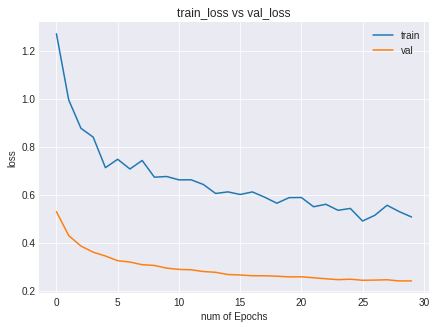

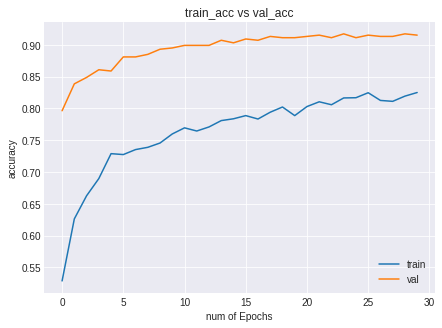

In [34]:
plot_acc_loss_eng(history)

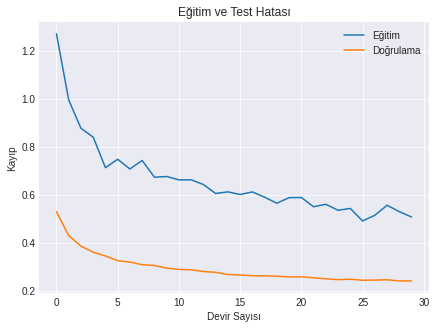

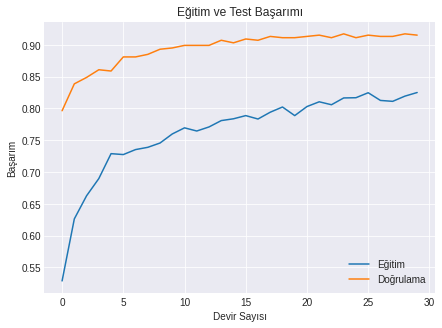

In [35]:
plot_acc_loss_tr(history)

#### **Metrics Results**

In [36]:
metric(X_test, y_test, model, model_name='InceptionResNet V2')



InceptionResNet V2  Model Accuracy Score:  0.934819897084048


InceptionResNet V2  Model Balanced Accuracy Score: 0.9360180723813857 


InceptionResNet V2  Model F1 Score: 0.9348198970840479 


InceptionResNet V2  Model Precision Score: 0.934819897084048 


InceptionResNet V2  Model Cohen Kappa Score: 0.9021846632051146 


InceptionResNet V2  Model Recall Score: 0.934819897084048 


In [37]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 6s 179ms/step - loss: 0.1901 - acc: 0.9348


[0.19011613726615906, 0.9348198771476746]

#### **Confusion Matrix**

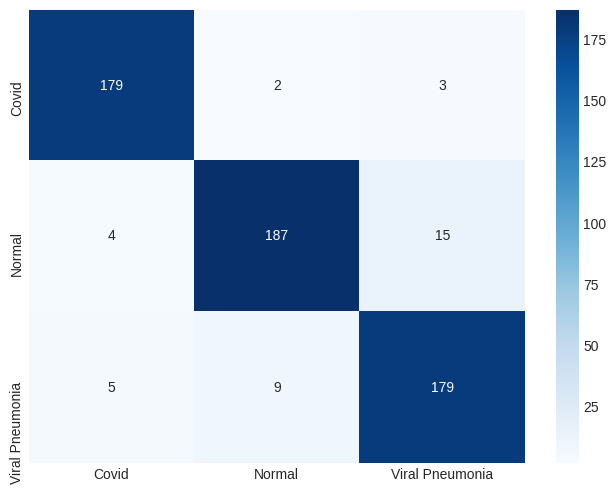

In [38]:
cm_eng(X_test, y_test, model)

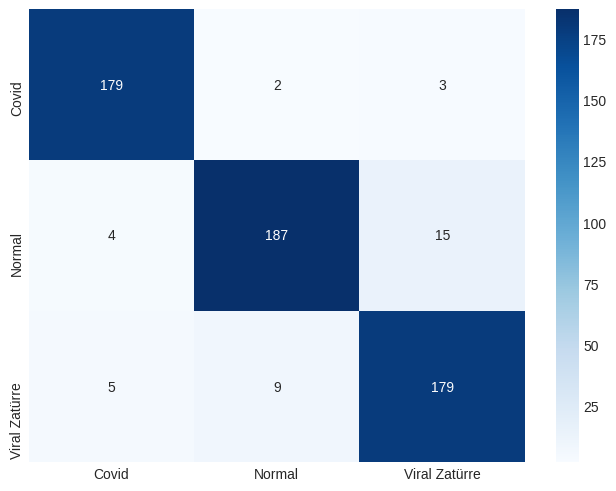

In [39]:
cm_tr(X_test, y_test, model)

#### **Roc Curve**

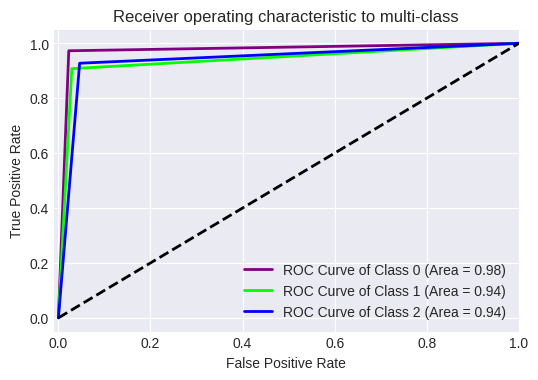

In [40]:
plot_roc_curve_eng(X_test, y_test, model)

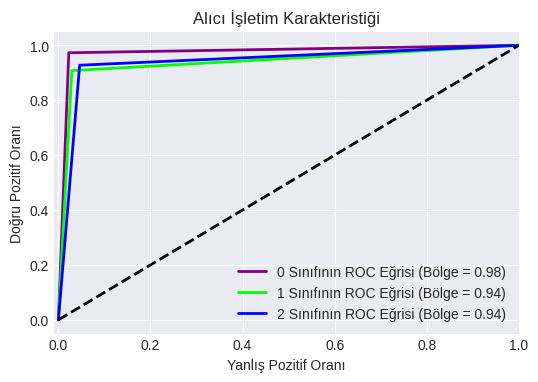

In [41]:
plot_roc_curve_tr(X_test, y_test, model)

## **DenseNet169**

In [42]:
densenet169 = DenseNet169(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
densenet169.trainable=False

51879936/51877672 [==============================] - 0s 0us/step


In [43]:
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = densenet169(inputs, training = True)

avg = GlobalAveragePooling2D()(x)

flat = Flatten()(avg)

batch = BatchNormalization()(flat)
drop = Dropout(0.25)(batch)
dense = Dense(512, activation='relu')(drop)
batch_2 = BatchNormalization()(dense)
drop_2 = Dropout(0.5)(batch_2)
outputs = tensorflow.keras.layers.Dense(3, activation=softmax)(drop_2)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics='acc')
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, 7, 7, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1664)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1664)              0         
_________________________________________________________________
batch_normalization_207 (Bat (None, 1664)              6656      
_________________________________________________________________
dropout_4 (Dropout)          (None, 1664)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               8524

#### **Train**

In [44]:
callback_list = [
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=5),
                 CSVLogger('densenet_169.csv', append=True, separator=';'),
                 ModelCheckpoint(filepath='densenet_169.h5', monitor='val_loss', mode='min',verbose=1, save_best_only=True)
]

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_split=.15,
                    batch_size=batch_size, 
                    callbacks=callback_list)

Epoch 1/30
351/351 [==============================] - 29s 58ms/step - loss: 1.4579 - acc: 0.4852 - val_loss: 0.7358 - val_acc: 0.6956

Epoch 00001: val_loss improved from inf to 0.73583, saving model to densenet_169.h5
Epoch 2/30
351/351 [==============================] - 17s 48ms/step - loss: 1.1715 - acc: 0.5660 - val_loss: 0.6040 - val_acc: 0.7581

Epoch 00002: val_loss improved from 0.73583 to 0.60404, saving model to densenet_169.h5
Epoch 3/30
351/351 [==============================] - 17s 48ms/step - loss: 0.9600 - acc: 0.6210 - val_loss: 0.5183 - val_acc: 0.8044

Epoch 00003: val_loss improved from 0.60404 to 0.51826, saving model to densenet_169.h5
Epoch 4/30
351/351 [==============================] - 17s 48ms/step - loss: 0.8516 - acc: 0.6840 - val_loss: 0.4615 - val_acc: 0.8226

Epoch 00004: val_loss improved from 0.51826 to 0.46150, saving model to densenet_169.h5
Epoch 5/30
351/351 [==============================] - 17s 48ms/step - loss: 0.7340 - acc: 0.7187 - val_loss: 0.4

#### **Plot Acc - Loss**

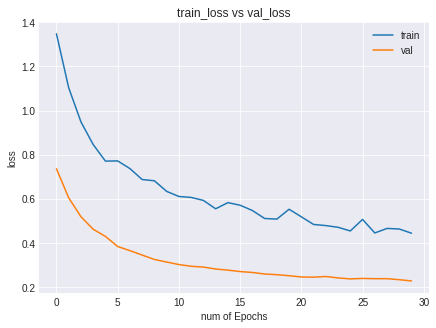

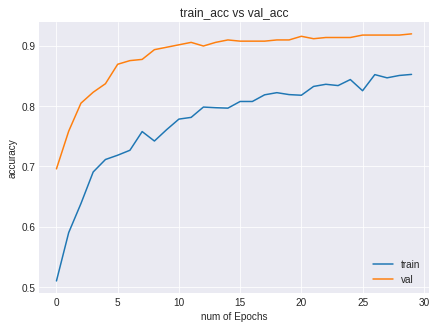

In [45]:
plot_acc_loss_eng(history)

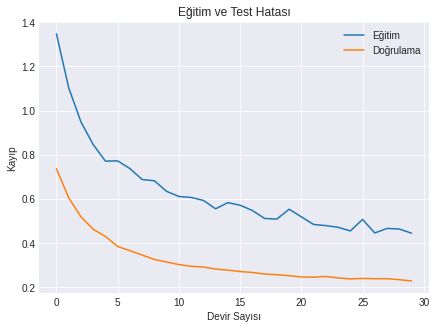

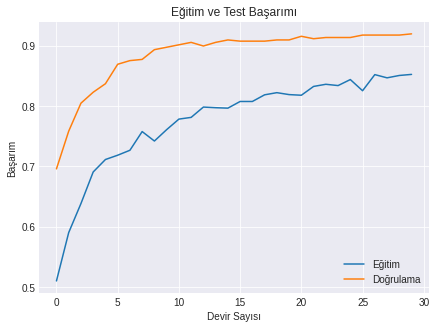

In [46]:
plot_acc_loss_tr(history)

#### **Metrics Results**

In [47]:
metric(X_test, y_test, model, model_name='DenseNet 169')



DenseNet 169  Model Accuracy Score:  0.9485420240137221


DenseNet 169  Model Balanced Accuracy Score: 0.9486115637286745 


DenseNet 169  Model F1 Score: 0.9485420240137221 


DenseNet 169  Model Precision Score: 0.9485420240137221 


DenseNet 169  Model Cohen Kappa Score: 0.9226913488569458 


DenseNet 169  Model Recall Score: 0.9485420240137221 


In [48]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 5s 114ms/step - loss: 0.1533 - acc: 0.9485


[0.15332835912704468, 0.9485419988632202]

#### **Confusion Matrix**

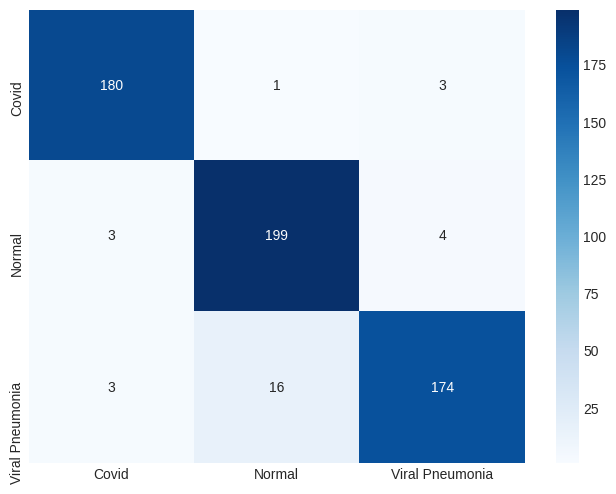

In [49]:
cm_eng(X_test, y_test, model)

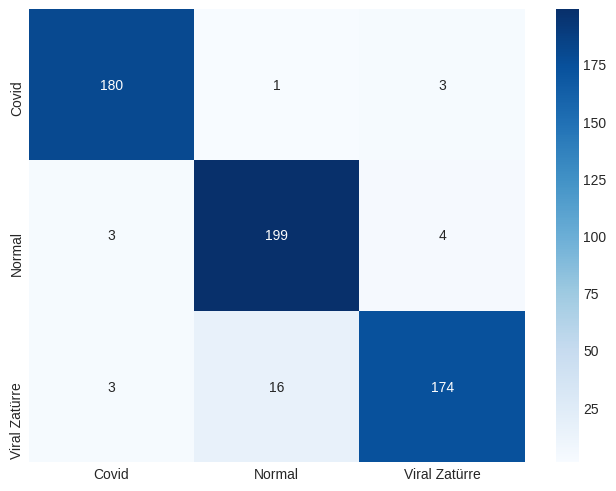

In [50]:
cm_tr(X_test, y_test, model)

#### **Roc Curve**

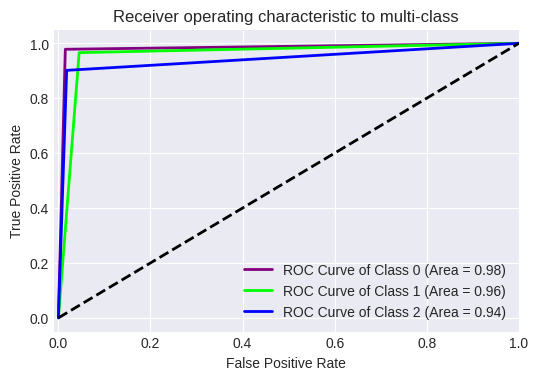

In [51]:
plot_roc_curve_eng(X_test, y_test, model)

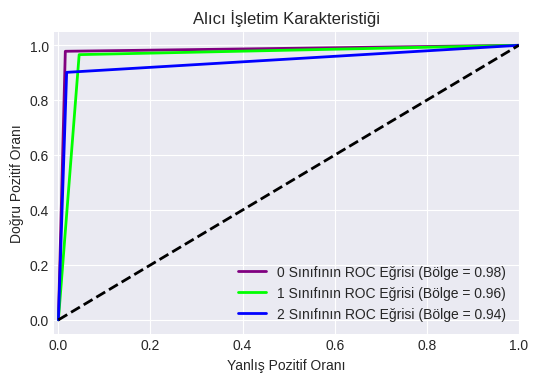

In [52]:
plot_roc_curve_tr(X_test, y_test, model)

## **VGG19**

In [53]:
vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
vgg19.trainable = False

80142336/80134624 [==============================] - 1s 0us/step


In [54]:
inputs = tensorflow.keras.Input(shape=(224, 224, 3))
x = vgg19(inputs, training = True)

avg = GlobalAveragePooling2D()(x)

flat = Flatten()(avg)

batch = BatchNormalization()(flat)
drop = Dropout(0.25)(batch)
dense = Dense(512, activation='relu')(drop)
batch_2 = BatchNormalization()(dense)
drop_2 = Dropout(0.5)(batch_2)
outputs = tensorflow.keras.layers.Dense(3, activation=softmax)(drop_2)
model = tensorflow.keras.Model(inputs, outputs)
model.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(), metrics='acc')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 512)               0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 512)               0         
_________________________________________________________________
batch_normalization_209 (Bat (None, 512)               2048      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               2626

#### **Train**

In [55]:
callback_list = [
                 ReduceLROnPlateau(monitor="val_loss", factor = 0.1, patience=5),
                 CSVLogger('vgg19.csv', append=True, separator=';'),
                 ModelCheckpoint(filepath='vgg19.h5', monitor='val_loss',mode='min',verbose=1,save_best_only=True)
]
history = model.fit(X_train, y_train,
                    epochs=epochs,
                    validation_split=.15,
                    batch_size=batch_size, 
                    callbacks=callback_list)

Epoch 1/30
351/351 [==============================] - 31s 80ms/step - loss: 1.9081 - acc: 0.3598 - val_loss: 1.0514 - val_acc: 0.5081

Epoch 00001: val_loss improved from inf to 1.05145, saving model to vgg19.h5
Epoch 2/30
351/351 [==============================] - 25s 72ms/step - loss: 1.5387 - acc: 0.4529 - val_loss: 1.0768 - val_acc: 0.5282

Epoch 00002: val_loss did not improve from 1.05145
Epoch 3/30
351/351 [==============================] - 25s 72ms/step - loss: 1.4422 - acc: 0.4674 - val_loss: 1.0136 - val_acc: 0.5746

Epoch 00003: val_loss improved from 1.05145 to 1.01361, saving model to vgg19.h5
Epoch 4/30
351/351 [==============================] - 25s 72ms/step - loss: 1.3445 - acc: 0.5060 - val_loss: 0.9451 - val_acc: 0.6089

Epoch 00004: val_loss improved from 1.01361 to 0.94511, saving model to vgg19.h5
Epoch 5/30
351/351 [==============================] - 25s 72ms/step - loss: 1.3529 - acc: 0.5376 - val_loss: 0.8819 - val_acc: 0.6411

Epoch 00005: val_loss improved from

#### **Plot Acc - Loss**

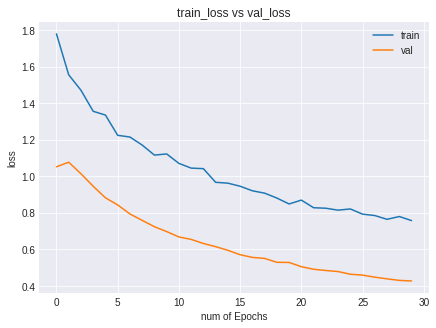

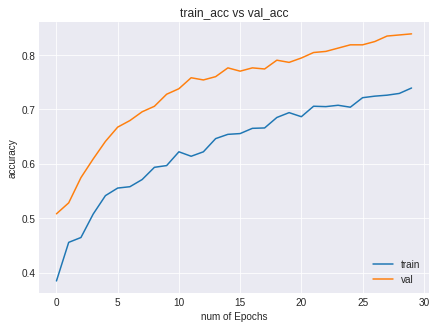

In [56]:
plot_acc_loss_eng(history)

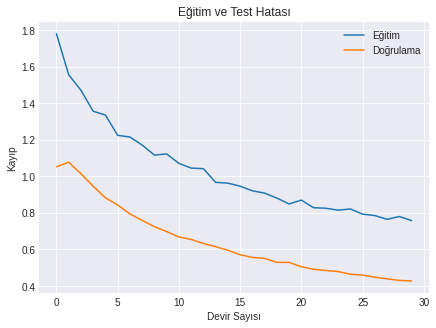

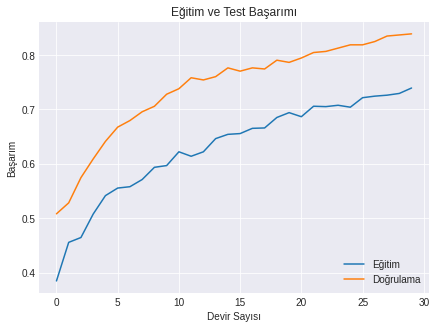

In [57]:
plot_acc_loss_tr(history)

#### **Metrics Results**

In [58]:
metric(X_test, y_test, model, model_name='VGG19')



VGG19  Model Accuracy Score:  0.8593481989708405


VGG19  Model Balanced Accuracy Score: 0.85970064542657 


VGG19  Model F1 Score: 0.8593481989708405 


VGG19  Model Precision Score: 0.8593481989708405 


VGG19  Model Cohen Kappa Score: 0.78873544424067 


VGG19  Model Recall Score: 0.8593481989708405 


In [59]:
model.evaluate(X_test, y_test)

19/19 [==============================] - 3s 154ms/step - loss: 0.4000 - acc: 0.8593


[0.4000450670719147, 0.8593481779098511]

#### **Confusion Matrix**

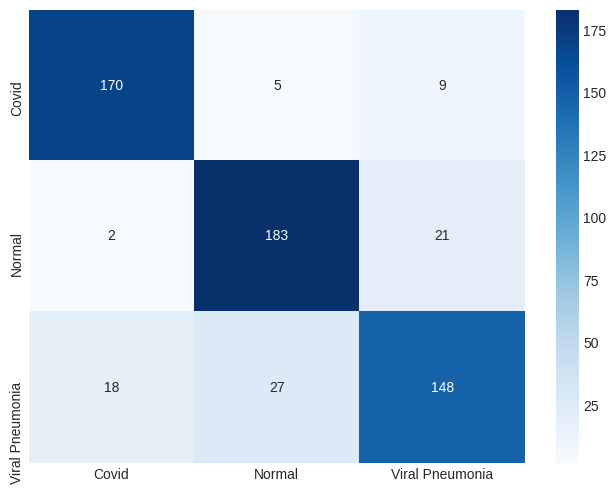

In [60]:
cm_eng(X_test, y_test, model)

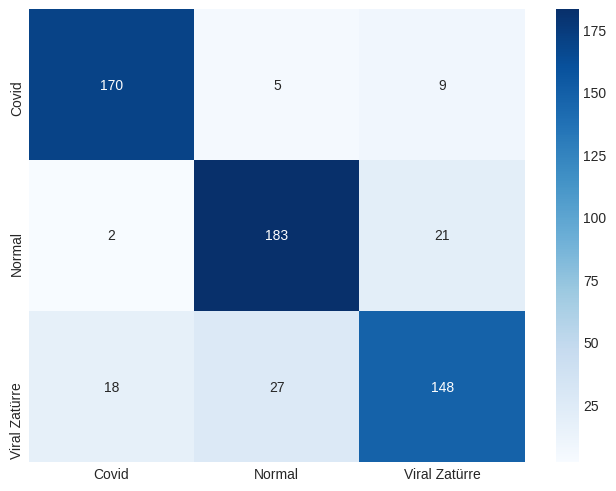

In [61]:
cm_tr(X_test, y_test, model)

#### **Roc Curve**

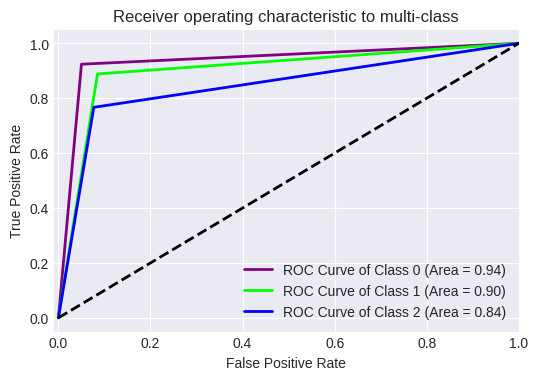

In [62]:
plot_roc_curve_eng(X_test, y_test, model)

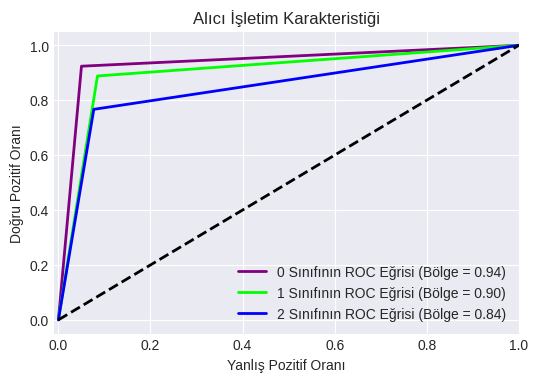

In [63]:
plot_roc_curve_tr(X_test, y_test, model)